# Normal Distributions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multivariate_normal

Density of univariate normal distributions.

Text(0.5, 1.0, 'Normal Distributions')

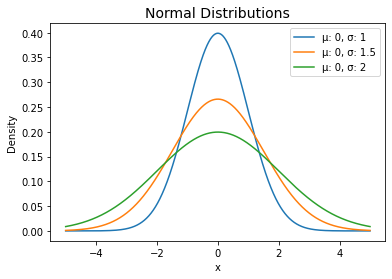

In [1]:
x = np.arange(-5, 5, 0.001)

#define multiple normal distributions
plt.plot(x, norm.pdf(x, 0, 1), label='μ: 0, σ: 1')
plt.plot(x, norm.pdf(x, 0, 1.5), label='μ: 0, σ: 1.5')
plt.plot(x, norm.pdf(x, 0, 2), label='μ: 0, σ: 2')

#add legend to plot
plt.legend()

#add axes labels and a title
plt.ylabel('Density')
plt.xlabel('x')
plt.title('Normal Distributions', fontsize=14)

Density of a bivariate normal distribution.

Text(0.5, 0, 'y')

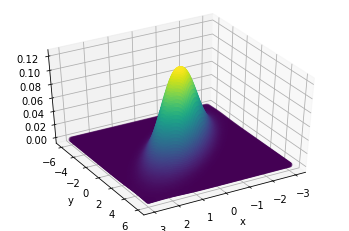

In [21]:
x = np.linspace(-3*1, 3*1, num=100)
y = np.linspace(-3*2, 3*2, num=100)
X, Y = np.meshgrid(x, y, indexing='xy') 
covM = np.array([[1, 1.5], [1.5, 4]])
distMVN = multivariate_normal(cov=covM)
Z = distMVN.pdf(np.dstack((X, Y)))
ax = plt.axes(projection="3d")
ax.scatter3D(X, Y, Z, c=Z, cmap = 'viridis')
ax.view_init(40, 60)
plt.xlabel("x")
plt.ylabel("y")